# Feature Meanings and Predication for Used Car Auction Prices 

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,accuracy_score
from sklearn.ensemble import RandomForestRegressor
import optuna
import lightgbm as lgb  

In [2]:
df = pd.read_csv('../input/used-car-auction-prices/car_prices.csv',error_bad_lines=False,warn_bad_lines=True)

b'Skipping line 408163: expected 16 fields, saw 17\nSkipping line 417837: expected 16 fields, saw 17\nSkipping line 421291: expected 16 fields, saw 17\nSkipping line 424163: expected 16 fields, saw 17\n'
b'Skipping line 427042: expected 16 fields, saw 17\nSkipping line 427045: expected 16 fields, saw 17\nSkipping line 434426: expected 16 fields, saw 17\nSkipping line 444503: expected 16 fields, saw 17\nSkipping line 453796: expected 16 fields, saw 17\n'
b'Skipping line 461599: expected 16 fields, saw 17\nSkipping line 461614: expected 16 fields, saw 17\n'
b'Skipping line 492486: expected 16 fields, saw 17\nSkipping line 497010: expected 16 fields, saw 17\nSkipping line 497013: expected 16 fields, saw 17\nSkipping line 499085: expected 16 fields, saw 17\nSkipping line 501457: expected 16 fields, saw 17\nSkipping line 505301: expected 16 fields, saw 17\nSkipping line 505308: expected 16 fields, saw 17\nSkipping line 520463: expected 16 fields, saw 17\n'
b'Skipping line 528998: expected 1

In [3]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


## Meaning of Special Features

Most of the features are easy to understand, but there are some special.

### vin: Vehicle identification number

The first special feature is `vin`. From `wikipedia`, `vin` means ***Vehicle identification number***.
> A vehicle identification number (VIN) (also called a chassis number or frame number) is a unique code, including a serial number, used by the automotive industry to identify individual motor vehicles, towed vehicles, motorcycles, scooters and mopeds, as defined in ISO 3779 (content and structure) and ISO 4030 (location and attachment).

>  A `vin` has 17 letters. Components of `vin` are `World manufacturer identifier`(1-3),`Vehicle descriptor section`(4-9) and	`Vehicle identifier section`(10-17).

> Country or region codes can be distinguished by the first 2 letters of `World manufacturer identifier`.

> https://en.wikipedia.org/wiki/Vehicle_identification_number#Components

So we can **add a feature `made_country` with the first 2 letters of `vin`**.


We can check the info of a vin by https://driving-tests.org/vin-decoder/. If we query the first vin of the data `5xyktca69fg566472`,we can get a result like :

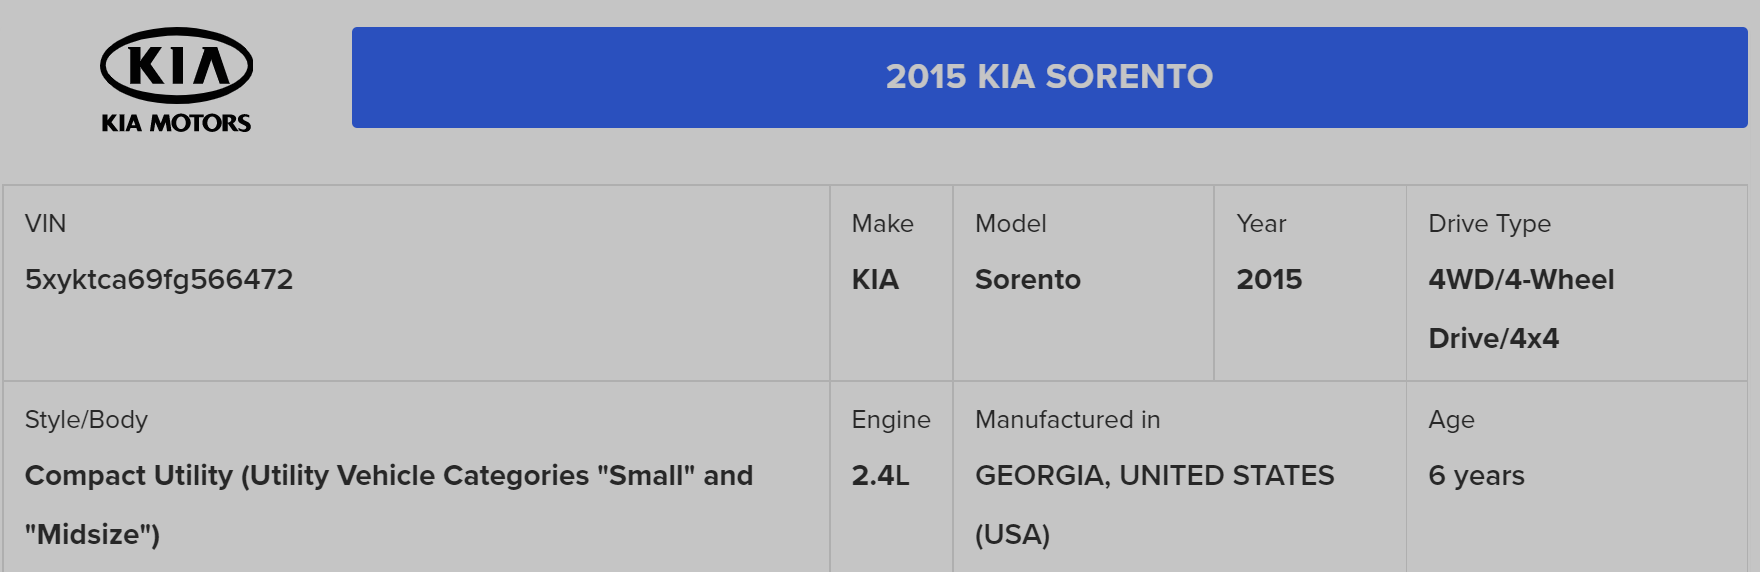

In [4]:
df['made_country']=df['vin'].map(lambda x:x[:2])

### mmr: Manheim Market Report

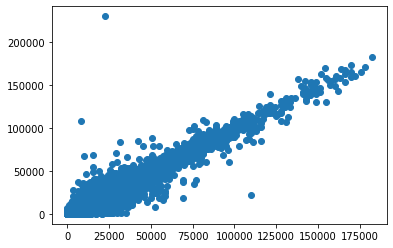

In [5]:
plt.scatter(df['mmr'],df['sellingprice'])
plt.show()

What really intersting is that `mmr` and `sellingprice` are so highly correlated. I did not find an explanation in `wikipedia`. But with Google I found this https://www.autoauctionmall.com/learning-center/what-does-mmr-mean/. 
> MMR in the car business stands for Manheim Market Report, an indicator of wholesale prices.

> Manheim is a company established in 1945 as a car auction company. It has grown to a very reputable company and its MMR is a baseline tool for wholesale car price determination. They base their price calculations on over 10 million transaction over the past 13-month period to .

I think that explained  why `mmr` and `sellingprice` are so close to each other in the figure. `mmr` is a evaluation made by the Manheim company.The company should make full use of all the infomation of car like `model`,`odometer` and so on.

So it is **not** a good idea to take `mmr` as a explanatory feature.

### odometer: measuring the distance traveled by a vehicle

In [6]:
df['odometer'].mean()

68323.19579679874

<AxesSubplot:ylabel='Frequency'>

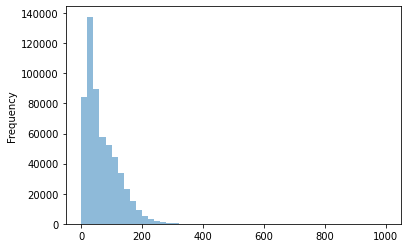

In [7]:
(df['odometer']/1000).plot.hist(bins=50, alpha=0.5)

`odometer` means:
> An odometer or odograph is an instrument used for measuring the distance traveled by a vehicle, such as a bicycle or car. The device may be electronic, mechanical, or a combination of the two (electromechanical). The noun derives from ancient Greek ὁδόμετρον, hodómetron, from ὁδός, hodós ("path" or "gateway") and μέτρον, métron ("measure"). Early forms of the odometer existed in the ancient Greco-Roman world as well as in ancient China. In countries using Imperial units or US customary units it is sometimes called a mileometer or milometer, the former name especially being prevalent in the United Kingdom and among members of the Commonwealth.
> https://en.wikipedia.org/wiki/Odometer

From the figure above,the unit of measurement may be `kilometers`. If that is true, the mean odometer of used cars is 68000 kilometers. And most of them are within 200000 kilometers.

### year: vehicle's model year

After checking several vins, the `year` equals vehicle's model year.

##  Data Preparation

 overview of the data


In [8]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['null_per'],axis=1,ascending=False)

,transmission,body,condition,trim,model,make,color,interior,odometer,mmr,saledate,sellingprice,year,seller,state,vin,made_country
null_per,0.11695,0.023613,0.021106,0.01906,0.018609,0.018434,0.00134,0.00134,0.000168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,object,object,float64,object,object,object,object,object,float64,int64,object,int64,int64,object,object,object,object
nuique,2,86,41,1975,973,96,20,17,172277,1101,3745,1887,34,14264,38,550296,103


handle missing values, drop them all since the the ratio is not high.


In [9]:
df=df.dropna(axis=0)

data extract


In [10]:
# extract `made_country` from vin
df['made_country']=df['vin'].map(lambda x:x[:2])

In [11]:
# extract selling date info
df['sale_datetime'] = pd.to_datetime(df['saledate'],utc=True)


In [12]:
df['sale_year']=df['sale_datetime'].dt.year.astype('int8')
df['sale_quarter']=df['sale_datetime'].dt.quarter.astype('int8')
df['sale_month']=df['sale_datetime'].dt.month.astype('int8')
df['sale_dayofweek']=df['sale_datetime'].dt.day_of_week.astype('int8')
df['sale_day']=df['sale_datetime'].dt.day.astype('int8')
df['sale_hour']= df['sale_datetime'].dt.hour.astype('int8')

In [13]:
# clean body
df['xbody']=df['body'].map(lambda x:str(x).lower())

In [14]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['null_per'],axis=1,ascending=False)

,year,mmr,sale_hour,sale_day,sale_dayofweek,sale_month,sale_quarter,sale_year,sale_datetime,made_country,...,color,odometer,condition,state,vin,transmission,body,trim,model,xbody
null_per,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,int64,int64,int8,int8,int8,int8,int8,int8,"datetime64[ns, UTC]",object,...,object,float64,float64,object,object,object,object,object,object,object
nuique,26,1099,21,31,6,8,4,2,3609,101,...,20,160427,41,34,465779,2,85,1507,768,45


In [15]:
# compress data
df['year']= df['year'].astype('int8')

## Insight

### When do people sell their car?

Check from `odometer` ,`condition` and `used_year`

<AxesSubplot:title={'center':'Distribution of odometer'}, ylabel='Frequency'>

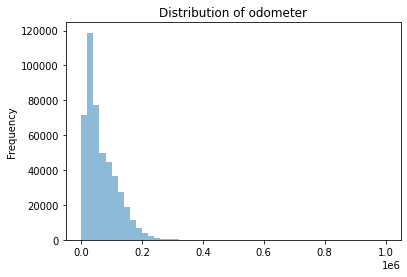

In [16]:
df['odometer'].plot.hist(bins=50,alpha=0.5,title='Distribution of odometer')

<AxesSubplot:title={'center':'Distribution of condition'}, ylabel='Frequency'>

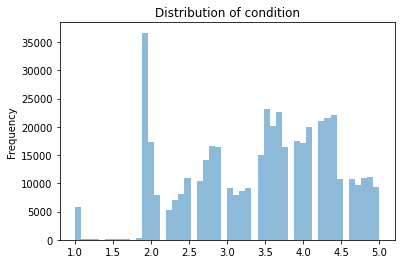

In [17]:
df['condition'].plot.hist(bins=50,alpha=0.5,title='Distribution of condition')

<AxesSubplot:title={'center':'Distribution of used_year'}>

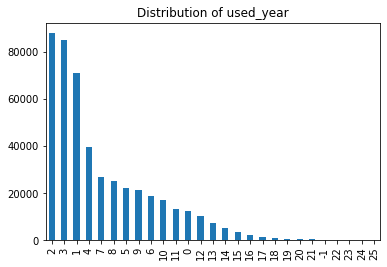

In [18]:
df['used_year']=df['sale_year']-df['year']
df['used_year'].value_counts().plot.bar(title='Distribution of used_year')

So  deals from the dataset indicate that people are more inclined to using their cars in 4 years, driving within 200,000 kilometers and sell cars with good or bad conditions.

### Should a seller choose to believe `mmr`?

In [19]:
df['sale_delta'] = df['sellingprice']-df['mmr']

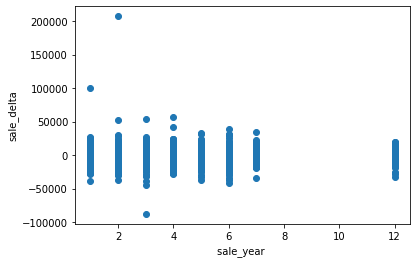

In [20]:
# condition vs sale delta
plt.scatter(df['sale_month'],df['sale_delta'])
plt.ylabel('sale_delta')
plt.xlabel('sale_year ')
plt.show()

In [21]:
# filter some outliner
df=df[df['sale_delta']<df['sale_delta'].max()]
df['sale_delta'].mean()

-147.03508526787132

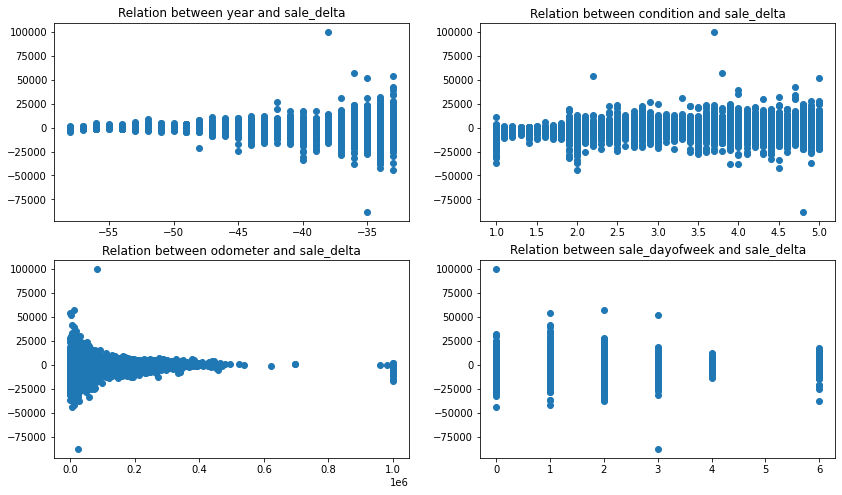

In [22]:
x_list =['year','condition','odometer','sale_dayofweek']
y = 'sale_delta'
x_len = len(x_list)
#
fig,ax=plt.subplots(2,2,figsize=(14,8))
for t in range(x_len):
    grid_x = df[x_list[t]]
    grid_y = df[y]
    ax[t//2,t%2].scatter(grid_x,grid_y)
    ax[t//2,t%2].set_title(f'Relation between {grid_x.name} and {grid_y.name}')
plt.show()

`sellingprice` is close and slightly lower than the `mmr` on average. But the `sellingprice` may be higher or lower than `mmr` .The variance goes up as `year` increase and as odometer down.
If someone dislike the variance the 4th day of week may be a good choice.


In [23]:
Xa=df['mmr'].values.reshape(-1, 1) 
ya=df['sellingprice'].values
linear_clfa = LinearRegression()
linear_clfa.fit(Xa,ya)
print(linear_clfa.score(Xa,ya))


0.9682079442714465


 Should a seller choose to believe `mmr`? 
 
 Yes, and `mmr` can be a good predict to the final `sellingprice` only if seller has access to `mmr`.And the access should not be free and takes some time.Recent year the variance became larger and larger.  
 
 Alternatively, we can try use basic info of a car to do a prediction.

## Prediction

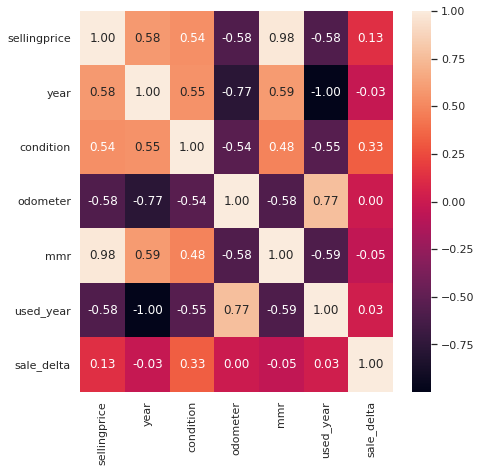

In [24]:
heatmap_col=['sellingprice','year','condition','odometer','mmr','used_year','sale_delta']
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(df[heatmap_col].corr(), annot=True, fmt=".2f");

In [25]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['nuique'],axis=1,ascending=True).T

,null_per,dtypes,nuique
sale_year,0.0,int8,2
transmission,0.0,object,2
sale_quarter,0.0,int8,4
sale_dayofweek,0.0,int8,6
sale_month,0.0,int8,8
interior,0.0,object,17
color,0.0,object,20
sale_hour,0.0,int8,21
year,0.0,int8,26
used_year,0.0,int8,27


In [26]:
choosed_cols = ['year','condition','odometer','sellingprice',
                'make','model','trim','transmission','state','color','interior',
                'sale_dayofweek','sale_month','made_country','xbody']

In [27]:
ff=df[choosed_cols].copy()

In [28]:
ff.dtypes

year                 int8
condition         float64
odometer          float64
sellingprice        int64
make               object
model              object
trim               object
transmission       object
state              object
color              object
interior           object
sale_dayofweek       int8
sale_month           int8
made_country       object
xbody              object
dtype: object

In [29]:
# One-Hot Encode 
cat_cols = ff.select_dtypes(include=['object']).columns
ff_1 = pd.get_dummies(ff[cat_cols],dummy_na=False,prefix_sep='_',drop_first=True)
ff_2 = ff.drop(cat_cols,axis=1)

gf = ff_1.merge(ff_2,left_index=True,right_index=True)

In [30]:
gf.dtypes

make_Aston Martin      uint8
make_Audi              uint8
make_BMW               uint8
make_Bentley           uint8
make_Buick             uint8
                      ...   
condition            float64
odometer             float64
sellingprice           int64
sale_dayofweek          int8
sale_month              int8
Length: 2544, dtype: object

In [31]:
gf.shape

(472335, 2544)

In [32]:
X_df = gf.drop(['sellingprice'],axis=1)
y_df = gf['sellingprice']


In [33]:
def objective(trial):
    data,target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    param = {
        "n_estimators":trial.suggest_int("n_estimators",20,200,log=True),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    score = r2_score(valid_y, pred_labels)
    return score


It 's better to run below codes **locally** ...

In [34]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-08-07 15:52:54,457] A new study created in memory with name: no-name-4be24a8b-63bb-4eba-859c-2cea106ab128
[W 2021-08-07 15:52:54,459] Trial 0 failed because of the following error: NameError("name 'X' is not defined")
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/_optimize.py", line 216, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-33-0719c8854fc4>", line 2, in objective
    data,target = X,y
NameError: name 'X' is not defined


NameError: name 'X' is not defined

In [ ]:
# one of the best params the optuna computed is 198
train_x, valid_x, train_y, valid_y = train_test_split(X_df.values, y_df.values,
                                                      test_size=0.25,random_state=100)
lgb_clf = lgb.LGBMRegressor(n_estimators=198)
lgb_clf.fit(train_x,train_y)
print(lgb_clf.score(valid_x,valid_y))


The output figure is similar to this... if the notebook is run locally.
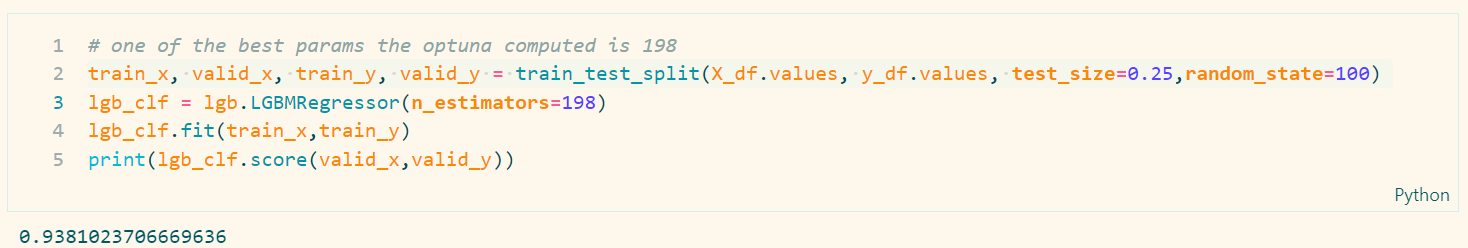

In [ ]:
#inspiration by https://www.kaggle.com/aleksandradeis/airbnb-seattle-reservation-prices-analysis#Machine-Learning
headers = ["name", "score"]
values = sorted(zip(X_df, lgb_clf.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:20]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:20]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (LightGBM)') 
plt.show()

The output figure is similar to this... if the notebook is run locally.
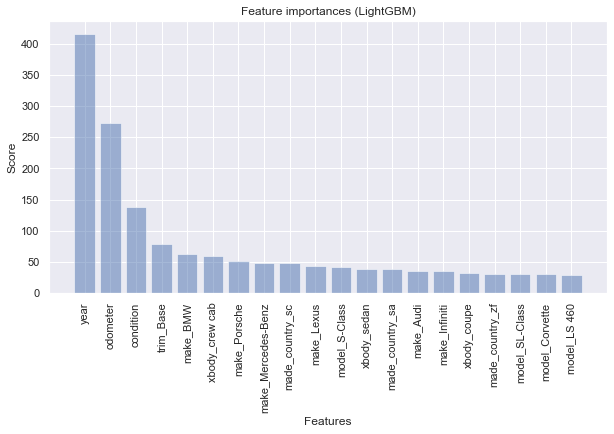

## Conclusion

In this analysis we tried to understand what influences used car 's selling price. We delete `mmr` from explained features, since it is a evaluated feature by business company. Alternatively, we tried to use basic info of a car to do a predict. The model has a similar `r2_score` with `mmr` and suggested `year`,`odometer`,`condition`  are the 3 features contributes most to the model.

Hope the predication is helpful to people who want to sell their cars!